In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten input
        x = torch.relu(self.fc1(x))
        x_hidden = torch.relu(self.fc2(x))
        out = self.fc3(x_hidden)
        return out, x_hidden  # Return both output and second layer (for t-SNE)

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

# Model initialization
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the MLP
def train(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

train(model, train_loader,100)

Epoch [1/100], Loss: 0.5578
Epoch [2/100], Loss: 0.3039
Epoch [3/100], Loss: 0.2671
Epoch [4/100], Loss: 0.2425
Epoch [5/100], Loss: 0.2247
Epoch [6/100], Loss: 0.2111
Epoch [7/100], Loss: 0.1958
Epoch [8/100], Loss: 0.1873
Epoch [9/100], Loss: 0.1768
Epoch [10/100], Loss: 0.1706
Epoch [11/100], Loss: 0.1631
Epoch [12/100], Loss: 0.1568
Epoch [13/100], Loss: 0.1562
Epoch [14/100], Loss: 0.1483
Epoch [15/100], Loss: 0.1453
Epoch [16/100], Loss: 0.1419
Epoch [17/100], Loss: 0.1411
Epoch [18/100], Loss: 0.1385
Epoch [19/100], Loss: 0.1344
Epoch [20/100], Loss: 0.1340
Epoch [21/100], Loss: 0.1306
Epoch [22/100], Loss: 0.1289
Epoch [23/100], Loss: 0.1273
Epoch [24/100], Loss: 0.1263
Epoch [25/100], Loss: 0.1254
Epoch [26/100], Loss: 0.1233
Epoch [27/100], Loss: 0.1210
Epoch [28/100], Loss: 0.1212
Epoch [29/100], Loss: 0.1187
Epoch [30/100], Loss: 0.1190
Epoch [31/100], Loss: 0.1183
Epoch [32/100], Loss: 0.1176
Epoch [33/100], Loss: 0.1138
Epoch [34/100], Loss: 0.1157
Epoch [35/100], Loss: 0

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Flattening the data for scikit-learn models
def flatten_data(dataset):
    data = []
    labels = []
    for img, label in dataset:
        data.append(img.view(-1).numpy())
        labels.append(label)
    return np.array(data), np.array(labels)

train_data, train_labels = flatten_data(train_dataset)
test_data, test_labels = flatten_data(test_dataset)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_data, train_labels)
rf_pred = rf.predict(test_data)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(train_data, train_labels)
log_reg_pred = log_reg.predict(test_data)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# MLP Evaluation
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    outputs, _ = model(images)
    _, mlp_pred = torch.max(outputs, 1)

# Confusion Matrix and F1-Score
def evaluate_model(pred, true_labels, model_name):
    f1 = f1_score(true_labels, pred, average='macro')
    print(f'{model_name} F1-Score: {f1:.4f}')

    cm = confusion_matrix(true_labels, pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

MLP F1-Score: 0.9586


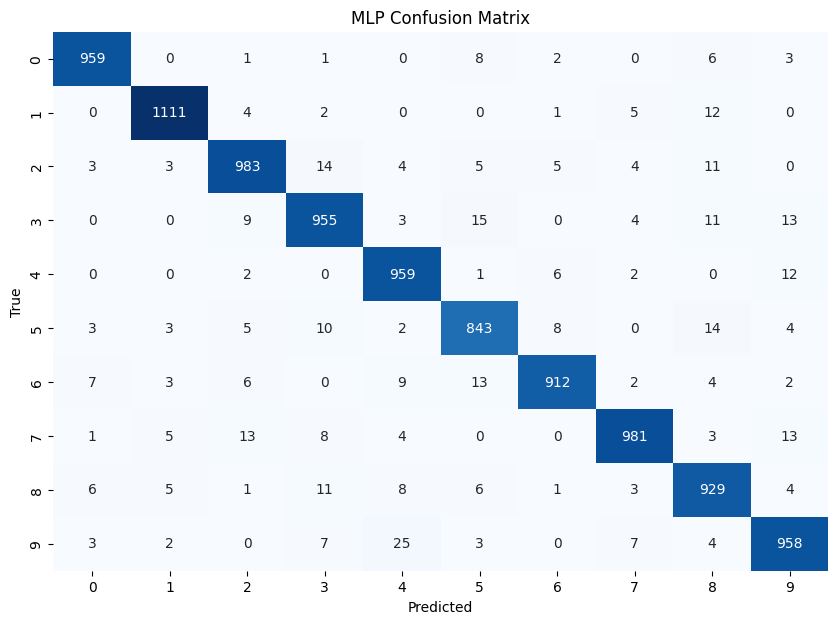

In [ ]:
evaluate_model(mlp_pred.numpy(), labels.numpy(), 'MLP')

Random Forest F1-Score: 0.9697


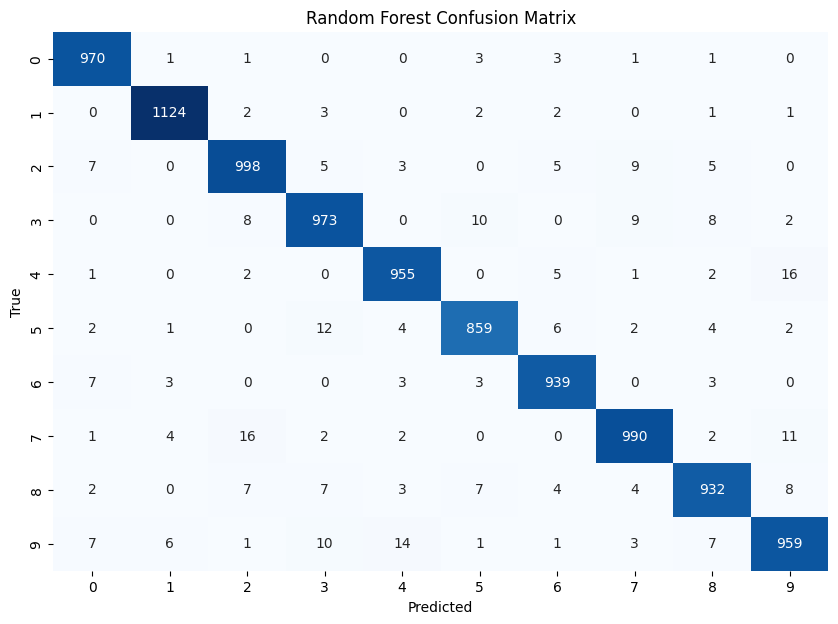

In [ ]:
evaluate_model(rf_pred, test_labels, 'Random Forest')

Logistic Regression F1-Score: 0.9242


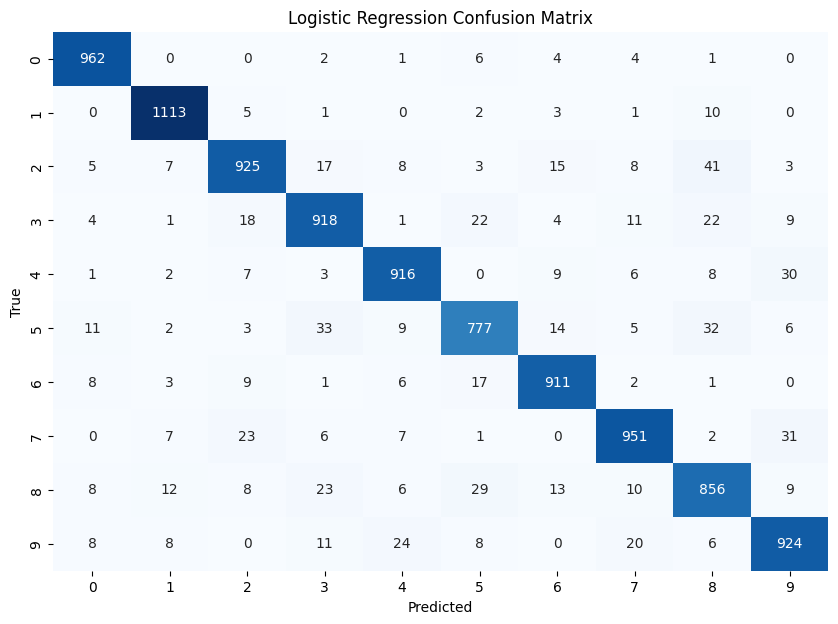

In [ ]:
evaluate_model(log_reg_pred, test_labels, 'Logistic Regression')

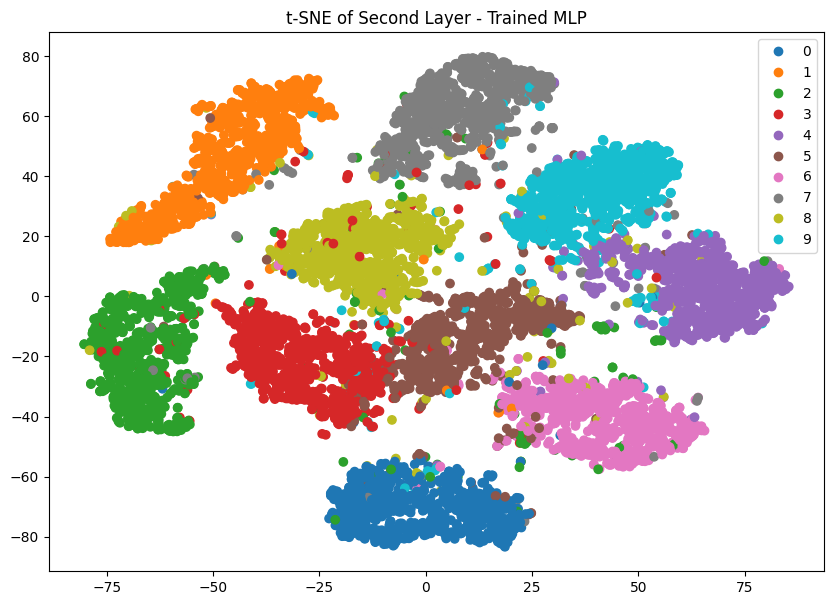

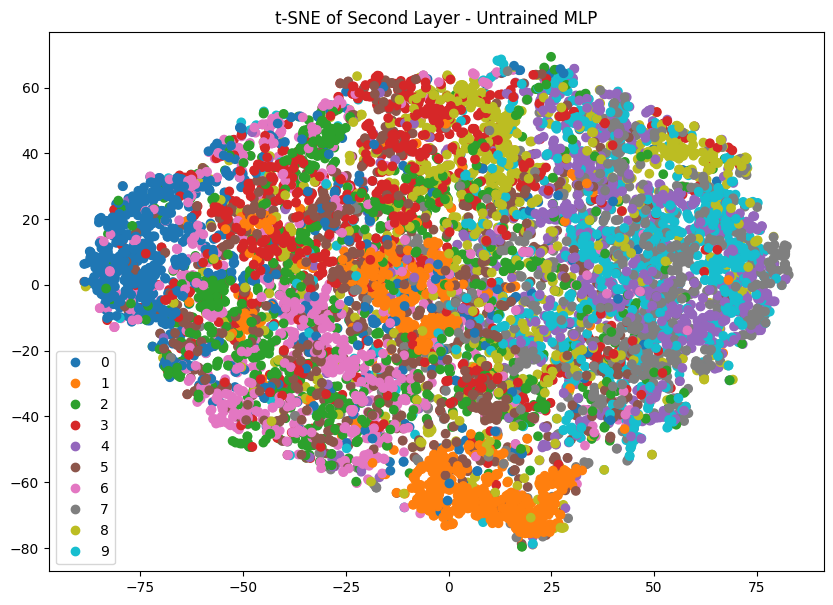

In [ ]:
# Perform t-SNE on the second layer of MLP (trained)
def plot_tsne(model, data_loader, model_name):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(data_loader))
        _, second_layer_output = model(images)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(second_layer_output)

    plt.figure(figsize=(10,7))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10')
    plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10)))
    plt.title(f't-SNE of Second Layer - {model_name}')
    plt.show()

# Plot t-SNE for trained model
plot_tsne(model, test_loader, 'Trained MLP')

# Plot t-SNE for untrained model
untrained_model = MLP()  # Initialize untrained model
plot_tsne(untrained_model, test_loader, 'Untrained MLP')


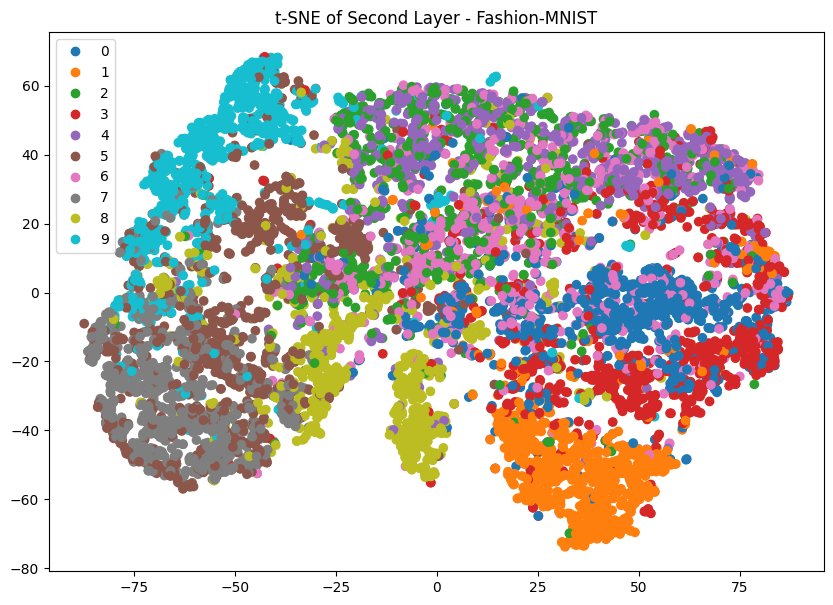

In [ ]:
# Load Fashion-MNIST dataset
fashion_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_test_loader = torch.utils.data.DataLoader(dataset=fashion_test_dataset, batch_size=10000, shuffle=False)

# MLP Predictions on Fashion-MNIST
with torch.no_grad():
    fashion_images, fashion_labels = next(iter(fashion_test_loader))
    _, second_layer_output_fashion = model(fashion_images)

# t-SNE for Fashion-MNIST
plot_tsne(model, fashion_test_loader, 'Fashion-MNIST')

# You may also compare t-SNE results for MNIST vs Fashion-MNIST embeddings
